In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import torchvision.models as models
from torchvision import transforms
import random
import cv2

In [2]:
class GRL(nn.Module):
    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff * gradOutput


class adaIN(nn.Module):

    def __init__(self, eps=1e-5):
        super(adaIN, self).__init__()
        self.eps = eps

    def forward(self, input, gamma, beta):
        in_mean, in_var = torch.mean(input, dim=[2, 3], keepdim=True), torch.var(input, dim=[2, 3], keepdim=True)
        out_in = (input - in_mean) / torch.sqrt(in_var + self.eps)
        out = out_in
        out = out * gamma.unsqueeze(2).unsqueeze(3) + beta.unsqueeze(2).unsqueeze(3)
        return out

class ResnetAdaINBlock(nn.Module):

    def __init__(self, dim):
        super(ResnetAdaINBlock, self).__init__()
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = adaIN()
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = adaIN()

    def forward(self, x, gamma, beta):
        out = self.conv1(x)
        out = self.norm1(out, gamma, beta)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.norm2(out, gamma, beta)
        return out+x

In [3]:
class Discriminator(nn.Module):
    def __init__(self, max_iter, num_domains):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, num_domains)
        self.ad_net = nn.Sequential(
            self.fc1,
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            self.fc2
        )
        self.grl_layer = GRL(max_iter)

    def forward(self, feature):
        adversarial_out = self.ad_net(self.grl_layer(feature))
        return adversarial_out

class SSAN_R(nn.Module):
    def __init__(self, ada_num=2, max_iter=4000, num_domains=1):
        super(SSAN_R, self).__init__()
        model_resnet = models.resnet18(pretrained=True)

        self.input_layer = nn.Sequential(
            model_resnet.conv1,
            model_resnet.bn1,
            model_resnet.relu,
            model_resnet.maxpool
        )
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.adaIN_layers = nn.ModuleList([ResnetAdaINBlock(256) for i in range(ada_num)])

        self.conv_final = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512)
        )
        self.cls_head = nn.Linear(512, 2, bias=True)

        self.gamma = nn.Linear(256, 256, bias=False)
        self.beta = nn.Linear(256, 256, bias=False)

        self.FC = nn.Sequential(
            nn.Linear(256, 256, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ada_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.ada_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.ada_conv3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256)
        )
        self.dis = Discriminator(max_iter, num_domains)

    def cal_gamma_beta(self, x1):
        x1 = self.input_layer(x1)
        x1_1 = self.layer1(x1)
        x1_2 = self.layer2(x1_1)
        x1_3 = self.layer3(x1_2)

        x1_4 = self.layer4(x1_3) # content feature
        
        x1_add = x1_1
        x1_add = self.ada_conv1(x1_add)+x1_2
        x1_add = self.ada_conv2(x1_add)+x1_3
        x1_add = self.ada_conv3(x1_add) # style feature tổng hợp

        gmp = torch.nn.functional.adaptive_max_pool2d(x1_add, 1)
        gmp_ = self.FC(gmp.view(gmp.shape[0], -1))
        gamma, beta = self.gamma(gmp_), self.beta(gmp_) # gamma, beta từ style feature

        domain_invariant = torch.nn.functional.adaptive_avg_pool2d(x1_4, 1).reshape(x1_4.shape[0], -1) #embedding dùng trong L_adv

        return x1_4, gamma, beta, domain_invariant

    def forward(self, input1, input2):
        x1, gamma1, beta1, domain_invariant = self.cal_gamma_beta(input1)
        x2, gamma2, beta2, _ = self.cal_gamma_beta(input2)

        # Self-assembly S(xi, xi)
        fea_x1_x1 = x1
        for i in range(len(self.adaIN_layers)):
            fea_x1_x1 = self.adaIN_layers[i](fea_x1_x1, gamma1, beta1)
        fea_x1_x1 = self.conv_final(fea_x1_x1)
        fea_x1_x1 = torch.nn.functional.adaptive_avg_pool2d(fea_x1_x1, 1)
        fea_x1_x1 = fea_x1_x1.reshape(fea_x1_x1.shape[0], -1)
        cls_x1_x1 = self.cls_head(fea_x1_x1)

        # Shuffle-assembly S(xi, xi*)
        fea_x1_x2 = x1
        for i in range(len(self.adaIN_layers)):
            fea_x1_x2 = self.adaIN_layers[i](fea_x1_x2, gamma2, beta2)
        fea_x1_x2 = self.conv_final(fea_x1_x2)
        fea_x1_x2 = torch.nn.functional.adaptive_avg_pool2d(fea_x1_x2, 1)
        fea_x1_x2 = fea_x1_x2.reshape(fea_x1_x2.shape[0], -1)

        dis_invariant = self.dis(domain_invariant)
        return cls_x1_x1, fea_x1_x1, fea_x1_x2, dis_invariant

In [4]:
class ContrastLoss(nn.Module):
    
    def __init__(self):
        super(ContrastLoss, self).__init__()
        pass

    def forward(self, anchor_fea, reassembly_fea, contrast_label):
        contrast_label = contrast_label.float()
        anchor_fea = anchor_fea.detach()
        loss = -(F.cosine_similarity(anchor_fea, reassembly_fea, dim=-1))
        loss = loss*contrast_label
        return loss.mean()

In [5]:
# Imports chung

import os
import math
import random
import time

import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# Cấu hình 

from types import SimpleNamespace

cfg = SimpleNamespace()

# Đường dẫn dữ liệu của bạn
cfg.data_dir      = "./dataset_processed"  # chỉnh nếu khác
cfg.result_path   = "./results"            # nơi lưu model, score, csv
cfg.result_name   = "ssan_custom"          # tên run

# Training settings
cfg.model_type    = "SSAN_R"   # hiện tại chỉ dùng SSAN_R (binary)

cfg.batch_size    = 32 
cfg.img_size      = 256
cfg.map_size      = 32
cfg.num_epochs    = 80   # Với early stop patience = 20
cfg.start_epoch   = 0         
cfg.print_freq    = 10

# Optimizer & scheduler
cfg.base_lr       = 5e-5
cfg.momentum      = 0.9
cfg.weight_decay  = 1e-4
cfg.step_size     = 15
cfg.gamma         = 0.5

# Augmentation mode: "o" (original), "p" (pure), "I" (ImageNet)
cfg.trans         = "o"      # Full augmentation - TỐT cho 40K images

cfg.debug_subset_size = None # None = dùng toàn bộ dataset

# Domain
DOMAIN_NAME_TO_ID = {
    "CUSTOM": 0,
    "CUSTOM2": 1,
    "MSU_MFSD": 2,
    "SiW": 3,
    "CUSTOM3": 4,
}
cfg.num_domains = len(DOMAIN_NAME_TO_ID)

# ===== EARLY STOPPING cho Kaggle (12h limit) =====
cfg.early_stop_patience = 20       # Giữ 20 epochs (đủ cho dataset lớn)
cfg.monitor_metric = "auc-hter"    # Monitor AUC - HTER (robust)

In [3]:
import csv
import os

# Tạo thư mục log
log_dir = os.path.join(cfg.result_path, cfg.result_name, "log")
os.makedirs(log_dir, exist_ok=True)

log_csv_path = os.path.join(log_dir, "training_log.csv")

# Tạo CSV header nếu file chưa tồn tại
if not os.path.exists(log_csv_path):
    with open(log_csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch", 
            "train_ce", "train_contra", "train_adv", "train_total",
            "val_acc", "val_auc", "val_hter", "val_fpr", "val_frr",
            "learning_rate", "best_metric", "early_stop_counter",
            "epoch_time", "timestamp"
        ])

# Biến history để vẽ biểu đồ
history = {
    "epoch": [],
    "train_total": [],
    "train_ce": [],
    "train_contra": [],
    "train_adv": [],
    "val_acc": [],
    "val_auc": [],
    "val_hter": [],
    "val_fpr": [],
    "val_frr": [],
    "learning_rate": [],
    "best_metric": [],
    "early_stop_counter": [],
    "epoch_time": [],
}


In [ ]:
# Transforms cho training / testing

class Normaliztion(object):
    """
    Chuẩn hóa ảnh về [-1, 1]: image = (image - 127.5) / 128
    Đồng thời map_x về [0,1]
    """
    def __call__(self, sample):
        image_x = sample['image_x']
        map_x   = sample['map_x']
        image_x = (image_x - 127.5) / 128.0
        sample['image_x'] = image_x
        sample['map_x']   = map_x / 255.0
        return sample


class Normaliztion_ImageNet(object):
    # Chuẩn hóa theo mean/std ImageNet
    def __init__(self):
        self.trans = transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __call__(self, sample):
        image_x = sample['image_x'] / 255.0
        image_x = self.trans(image_x)
        sample['image_x'] = image_x
        map_x = sample['map_x']
        sample['map_x'] = map_x / 255.0
        return sample


class ToTensor(object):
    # Convert numpy image HxWxC (BGR/RGB) -> torch Tensor CxHxW
    def __call__(self, sample):
        image_x, map_x, spoofing_label = sample['image_x'], sample['map_x'], sample['label']
        # Chuyển từ HxWxC (BGR) sang CxHxW (RGB)
        image_x = image_x[:, :, ::-1].transpose((2, 0, 1))  # BGR -> RGB, HWC -> CHW
        image_x = np.array(image_x)
        map_x   = np.array(map_x)

        spoofing_label_np = np.array([0], dtype=np.longlong)
        spoofing_label_np[0] = spoofing_label

        sample['image_x'] = torch.from_numpy(image_x.astype(np.float32)).float()
        sample['map_x']   = torch.from_numpy(map_x.astype(np.float32)).float()
        sample['label']   = torch.from_numpy(spoofing_label_np).long()
        return sample


class Cutout(object):
    def __init__(self, length=50):
        self.length = length

    def __call__(self, sample):
        img = sample['image_x']
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)
        length_new = np.random.randint(1, self.length)
        y1 = np.clip(y - length_new // 2, 0, h)
        y2 = np.clip(y + length_new // 2, 0, h)
        x1 = np.clip(x - length_new // 2, 0, w)
        x2 = np.clip(x + length_new // 2, 0, w)
        mask[y1:y2, x1:x2] = 0.0
        mask = torch.from_numpy(mask).float()
        mask = mask.expand_as(img)
        img *= mask
        sample['image_x'] = img
        return sample

class RandomHorizontalFlip(object):
    def __call__(self, sample):
        if random.random() < 0.5:
            image_x = sample["image_x"]
            map_x   = sample["map_x"]
            image_x = cv2.flip(image_x, 1)
            map_x   = cv2.flip(map_x, 1)
            sample["image_x"] = image_x
            sample["map_x"]   = map_x
        return sample

class Contrast_and_Brightness(object):
    def __call__(self, sample):
        image_x = sample["image_x"]
        # Tăng range để robust hơn với webcam
        gamma = random.randint(-50, 50)  # Thay vì -40, 40
        alpha = random.uniform(0.4, 1.6)  # Thay vì 0.5, 1.5
        image_x = cv2.addWeighted(image_x, alpha, image_x, 0, gamma)
        sample["image_x"] = image_x
        return sample


class RandomRotation(object):
    """Thêm rotation nhỏ để robust với góc nghiêng"""
    def __init__(self, max_angle=10):
        self.max_angle = max_angle
    
    def __call__(self, sample):
        if random.random() < 0.5:
            image_x = sample["image_x"]
            map_x = sample["map_x"]
            
            angle = random.uniform(-self.max_angle, self.max_angle)
            h, w = image_x.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            
            image_x = cv2.warpAffine(image_x, M, (w, h))
            map_x = cv2.warpAffine(map_x, M, (map_x.shape[1], map_x.shape[0]))
            
            sample["image_x"] = image_x
            sample["map_x"] = map_x
        return sample


class GaussianBlur(object):
    """Thêm blur để robust với webcam kém chất lượng"""
    def __call__(self, sample):
        if random.random() < 0.3:  # 30% chance
            image_x = sample["image_x"]
            ksize = random.choice([3, 5])
            image_x = cv2.GaussianBlur(image_x, (ksize, ksize), 0)
            sample["image_x"] = image_x
        return sample


def transformer_train():
    return transforms.Compose([
        Contrast_and_Brightness(),
        RandomHorizontalFlip(),
        RandomRotation(max_angle=10),  # THÊM MỚI
        GaussianBlur(),                # THÊM MỚI
        ToTensor(),
        Cutout(),
        Normaliztion(),
    ])


def transformer_train_pure():
    return transforms.Compose([
        RandomHorizontalFlip(),
        ToTensor(),
        Normaliztion(),
    ])


def transformer_train_ImageNet():
    return transforms.Compose([
        RandomHorizontalFlip(),
        ToTensor(),
        Normaliztion_ImageNet(),
    ])


def transformer_test_image():
    """
    Transform dùng cho test trên ảnh đơn.
    ⚠️ QUAN TRỌNG: Test set KHÔNG được augment (theo paper SSAN)
    Chỉ resize + normalize, KHÔNG flip, KHÔNG cutout, KHÔNG contrast/brightness
    """
    return transforms.Compose([
        ToTensor(),
        Normaliztion(),
    ])


In [9]:
# Dataset

class CustomImageDataset(Dataset):
    """
    Giả định list_filtered.csv có cột:
      - label: 1 (live), 0 (not_live)
      - path: đường dẫn tương đối từ data_dir (vd: live/anh1.jpg)
      - domain: tên miền (vd: CUSTOM)
    """
    def __init__(self, csv_file, root_dir, transform=None, img_size=256, map_size=32, default_domain="CUSTOM"):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size
        self.map_size = map_size
        self.default_domain = default_domain

        # Nếu file csv KHÔNG có cột domain, ta thêm domain mặc định
        if "domain" not in self.data.columns:
            self.data["domain"] = default_domain  # = CUSTOM

        # Nếu CSV có cột 'filename' thì dùng nó làm path
        if "path" not in self.data.columns:
            if "filename" in self.data.columns:
                self.data["path"] = self.data["filename"]
            else:
                raise ValueError("CSV cần cột 'path' hoặc 'filename'.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row   = self.data.iloc[idx]
        rel_path = row["path"]
        label = int(row["label"])
        domain_name = row["domain"]

        img_path = os.path.join(self.root_dir, rel_path)

        # đọc ảnh BGR
        image_x = cv2.imread(img_path)
        if image_x is None:
            raise RuntimeError(f"Không đọc được ảnh: {img_path}")
        image_x = cv2.resize(image_x, (self.img_size, self.img_size))

        # SSAN_R không dùng map_x nhưng solver yêu cầu, ta cho zeros
        map_x = np.zeros((self.map_size, self.map_size), dtype=np.float32)

        UUID = DOMAIN_NAME_TO_ID.get(domain_name, 0)

        sample = {
            "image_x": image_x,
            "map_x": map_x,
            "label": label,
            "UUID": UUID,
        }

        if self.transform:
            sample = self.transform(sample)

        return sample


In [8]:
# Utils, optimizer, metrics

# AvgrageMeter & check_folder
class AvgrageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        val = float(val)
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt if self.cnt != 0 else 0.0


def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir


# Optimizer
def get_optimizer(name, model, lr, momentum=0.9, weight_decay=0.0005):
    if name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif name == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise NotImplementedError
    return optimizer


# Metrics HTER, AUC
from sklearn.metrics import roc_curve, auc

def get_err_threhold(fpr, tpr, threshold):
    differ_tpr_fpr_1 = tpr + fpr - 1.0
    right_index = np.argmin(np.abs(differ_tpr_fpr_1))
    best_th = threshold[right_index]
    err = fpr[right_index]
    return err, best_th, right_index

def performances_val_from_scores(scores, labels):
    """
    Tính trực tiếp từ list scores, labels.
    scores: list/ndarray float (score lớn = live)
    labels: list/ndarray float (1=live,0=spoof)
    """
    fpr, tpr, threshold = roc_curve(labels, scores, pos_label=1)
    auc_test = auc(fpr, tpr)
    val_err, val_threshold, right_index = get_err_threhold(fpr, tpr, threshold)

    # type1, type2: giống performance.py
    data = [{'score': s, 'label': l} for s, l in zip(scores, labels)]
    type1 = len([d for d in data if d['score'] < val_threshold and d['label'] == 1])
    type2 = len([d for d in data if d['score'] > val_threshold and d['label'] == 0])
    count = len(data)
    val_ACC = 1 - (type1 + type2) / count if count > 0 else 0.0

    FRR = 1 - tpr  # FRR = 1 - TPR
    HTER = (fpr + FRR) / 2.0

    return val_ACC, fpr[right_index], FRR[right_index], HTER[right_index], auc_test, val_err


In [ ]:
# Khởi tạo DataLoader, model, optimizer, scheduler

# Chọn transform train theo cfg.trans
if cfg.trans == "o":
    train_transform = transformer_train()
elif cfg.trans == "p":
    train_transform = transformer_train_pure()
elif cfg.trans == "I":
    train_transform = transformer_train_ImageNet()
else:
    raise ValueError(f"Unknown trans mode: {cfg.trans}")

test_transform = transformer_test_image()

csv_path = os.path.join(cfg.data_dir, "list_filtered.csv")

full_dataset = CustomImageDataset(
    csv_file=csv_path,
    root_dir=cfg.data_dir,
    transform=None,  # sẽ áp dụng transform riêng cho train/test
    img_size=cfg.img_size,
    map_size=cfg.map_size,
)

# =========================================================
# PROTOCOL TỐI ƯU CHO WEBCAM INFERENCE
# =========================================================
import itertools
from torch.utils.data import Dataset

df = full_dataset.data  # DataFrame bên trong CustomImageDataset (path, label, domain)

# ===== CHỌN PROTOCOL =====
# 🎯 KHUYẾN NGHỊ CHO WEBCAM: Train trên ALL domains, Test split 80/20

# PROTOCOL A: MIXED ALL DOMAINS (BEST for Webcam Deployment) ⭐⭐⭐
protocol = "ALL_DOMAINS_80_20_SPLIT"
all_domains = ["CUSTOM", "CUSTOM2", "MSU_MFSD", "SiW", "CUSTOM3"]

print(f"\n{'='*80}")
print(f"📋 PROTOCOL: {protocol}")
print(f"{'='*80}")
print(f"🔵 Train: 80% samples từ tất cả {len(all_domains)} domains")
print(f"🟢 Val  : 20% samples từ tất cả {len(all_domains)} domains")
print(f"{'='*80}\n")

# ===== SPLIT 80/20 CHO TỪNG DOMAIN =====
train_idx_list = []
test_idx_list = []

for dom_name in all_domains:
    dom_df = df[df["domain"] == dom_name]
    dom_indices = dom_df.index.to_numpy()
    
    if len(dom_indices) == 0:
        print(f"⚠️  WARNING: Domain '{dom_name}' không có sample nào!")
        continue
    
    # Shuffle indices
    np.random.shuffle(dom_indices)
    
    # Split 80/20
    split_point = int(0.8 * len(dom_indices))
    dom_train = dom_indices[:split_point]
    dom_val = dom_indices[split_point:]
    
    train_idx_list.append(dom_train)
    test_idx_list.append(dom_val)
    
    print(f"✓ Domain '{dom_name}': {len(dom_train)} train, {len(dom_val)} val (total: {len(dom_indices)})")

# Gộp tất cả indices
if len(train_idx_list) == 0:
    raise ValueError("❌ Không có sample nào cho training!")
if len(test_idx_list) == 0:
    raise ValueError("❌ Không có sample nào cho validation!")

train_idx = np.concatenate(train_idx_list)
test_idx  = np.concatenate(test_idx_list)

# Shuffle để đảm bảo random
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

print(f"\n{'─'*80}")
print(f"📊 DATASET SUMMARY:")
print(f"   Train: {len(train_idx)} samples ({len(all_domains)} domains)")
print(f"   Val  : {len(test_idx)} samples ({len(all_domains)} domains)")
print(f"   Ratio: {len(train_idx)/(len(train_idx)+len(test_idx))*100:.1f}% / {len(test_idx)/(len(train_idx)+len(test_idx))*100:.1f}%")
print(f"{'─'*80}\n")

train_subset = torch.utils.data.Subset(full_dataset, train_idx)
test_subset  = torch.utils.data.Subset(full_dataset, test_idx)

# Gán transform cho từng subset bằng cách bọc lại
class TransformWrapper(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        sample = self.subset[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

train_set = TransformWrapper(train_subset, train_transform)
test_set  = TransformWrapper(test_subset,  test_transform)

if cfg.debug_subset_size is not None:
    train_set = torch.utils.data.Subset(train_set, range(0, min(cfg.debug_subset_size, len(train_set))))
    test_set  = torch.utils.data.Subset(test_set,  range(0, min(cfg.debug_subset_size,  len(test_set))))

# ===== DATALOADER CHO KAGGLE =====
# Kaggle có CPU mạnh → Tăng num_workers để load data nhanh hơn
# T4 GPU nhanh → Cần data loading không bị bottleneck
train_loader = DataLoader(
    train_set, 
    batch_size=cfg.batch_size, 
    shuffle=True,  
    num_workers=4,      # ⭐ Tăng từ 0 → 4 (tận dụng CPU Kaggle)
    pin_memory=True,    # ⭐ Tăng tốc transfer CPU → GPU
    persistent_workers=True  # ⭐ Giữ workers alive giữa các epoch
)
test_loader  = DataLoader(
    test_set,  
    batch_size=cfg.batch_size, 
    shuffle=False, 
    num_workers=2,      # Val set nhỏ hơn → chỉ cần 2 workers
    pin_memory=True
)

print("Train samples:", len(train_set))
print("Test samples :", len(test_set))
print(f"Batch size: {cfg.batch_size} | Num workers: 4 (train), 2 (val)")

# Khởi tạo model SSAN_R
max_iter = cfg.num_epochs * max(1, len(train_loader))
model = SSAN_R(max_iter=max_iter, num_domains=cfg.num_domains)

# ===== MULTI-GPU SETUP (KAGGLE T4 x2) =====
# Kaggle có 2 GPU T4 → Dùng DataParallel để train nhanh gấp đôi
if torch.cuda.device_count() > 1:
    print(f"🚀 Sử dụng {torch.cuda.device_count()} GPUs: DataParallel enabled!")
    model = nn.DataParallel(model)  # Wrap model để dùng multi-GPU
else:
    print(f"⚠️ Chỉ có 1 GPU, training trên single GPU")

model = model.to(device)

# Optimizer & scheduler
optimizer = get_optimizer("adam", model, lr=cfg.base_lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)

# OPTION 1: StepLR (hiện tại)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=cfg.step_size, gamma=cfg.gamma)

# OPTION 2: CosineAnnealingLR (BETTER - smooth decay) ⭐
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=cfg.num_epochs,  # Giảm dần trong toàn bộ training
    eta_min=1e-6           # Min LR
)

print(f"Using CosineAnnealingLR: {cfg.base_lr} → 1e-6 over {cfg.num_epochs} epochs")

# Loss
binary_fuc = nn.CrossEntropyLoss()  # L_cls (SSAN_R)
contra_fun = ContrastLoss()         # L_contra



📋 PROTOCOL: ALL_DOMAINS_80_20_SPLIT
🔵 Train: 80% samples từ tất cả 5 domains
🟢 Val  : 20% samples từ tất cả 5 domains

✓ Domain 'CUSTOM': 5368 train, 1342 val (total: 6710)
✓ Domain 'CUSTOM2': 3996 train, 1000 val (total: 4996)
✓ Domain 'MSU_MFSD': 1582 train, 396 val (total: 1978)
✓ Domain 'SiW': 6068 train, 1518 val (total: 7586)
✓ Domain 'CUSTOM3': 15061 train, 3766 val (total: 18827)

────────────────────────────────────────────────────────────────────────────────
📊 DATASET SUMMARY:
   Train: 32075 samples (5 domains)
   Val  : 8022 samples (5 domains)
   Ratio: 80.0% / 20.0%
────────────────────────────────────────────────────────────────────────────────

Train samples: 32075
Test samples : 8022


d:\CODE\face-anti-spoofing-2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CODE\face-anti-spoofing-2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using CosineAnnealingLR: 0.0001 → 1e-6 over 100 epochs


In [13]:
# ===== RESUME TRAINING =====
# Để resume từ checkpoint, set resume=True và chỉ định đường dẫn

resume = False  # Đổi thành True để resume training
resume_checkpoint = "results/ssan_custom/model/last_model2.pth"
reset_early_stop = False  # True = reset early stopping counter khi resume

if resume and os.path.exists(resume_checkpoint):
    print(f"==> Loading checkpoint from {resume_checkpoint}")
    checkpoint = torch.load(resume_checkpoint, map_location=device)
    
    # Load model state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Load optimizer và scheduler
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    # Load training state
    cfg.start_epoch = checkpoint['epoch']
    best_metric = checkpoint['best_metric']
    no_improve = checkpoint['no_improve']
    
    # RESET EARLY STOPPING nếu muốn train tiếp sau khi bị stop
    if reset_early_stop:
        no_improve = 0
        print("==> Early stopping counter đã được RESET về 0")
    
    # Load history nếu có
    if 'history' in checkpoint:
        history = checkpoint['history']
    
    print(f"==> Resumed from epoch {cfg.start_epoch}")
    print(f"==> Best metric: {best_metric:.4f}")
    print(f"==> Early stopping counter: {no_improve}/{cfg.early_stop_patience}")
else:
    if resume:
        print(f"Checkpoint {resume_checkpoint} không tồn tại, bắt đầu training từ đầu.")
    print("Starting training from scratch...")

Starting training from scratch...


In [14]:
# ===== KIỂM TRA CHECKPOINT =====
# Xem thông tin epoch, metrics trong checkpoint

checkpoint_path = "results/ssan_custom/model/last_model.pth"

if os.path.exists(checkpoint_path):
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    
    print("=" * 50)
    print("📦 THÔNG TIN CHECKPOINT:")
    print("=" * 50)
    print(f"✓ Epoch đã train: {ckpt['epoch']}")
    print(f"✓ Best metric: {ckpt['best_metric']:.4f}")
    print(f"✓ Early stopping counter: {ckpt['no_improve']}")
    print(f"✓ Số epochs trong history: {len(ckpt['history']['epoch'])}")
    
    if len(ckpt['history']['epoch']) > 0:
        print(f"\n📊 Epoch cuối cùng:")
        print(f"  - AUC: {ckpt['history']['val_auc'][-1]:.4f}")
        print(f"  - ACC: {ckpt['history']['val_acc'][-1]:.4f}")
        print(f"  - HTER: {ckpt['history']['val_hter'][-1]:.4f}")
    
    print("\n💡 Để resume, set: resume = True")
    print(f"   Training sẽ tiếp tục từ epoch {ckpt['epoch']}")
else:
    print(f"❌ Không tìm thấy checkpoint: {checkpoint_path}")

❌ Không tìm thấy checkpoint: results/ssan_custom/model/last_model.pth


# 📋 Config cho Kaggle T4 x2

**Thiết lập**: Batch 32 | LR 5e-5 | 80 epochs | Early stop 20

**Thời gian**: ~1000 iter/epoch × 80 epochs = ~6-8 giờ

**Lưu ý**: Auto-save mỗi 10 epochs | Kaggle timeout 12h


In [ ]:
# ===== AUTO-SAVE CHECKPOINT MỖI N EPOCHS (CHO KAGGLE) =====
# Phòng trường hợp Kaggle timeout, lưu checkpoint định kỳ

import os

# Tạo thư mục backup checkpoints
backup_dir = os.path.join(cfg.result_path, cfg.result_name, "model", "backups")
os.makedirs(backup_dir, exist_ok=True)

# Config auto-save
auto_save_interval = 10  # Lưu mỗi 10 epochs

print(f"💾 Auto-save checkpoint: Mỗi {auto_save_interval} epochs")
print(f"📁 Backup folder: {backup_dir}")
print(f"⏰ Kaggle timeout: 12 giờ (training ước tính: ~5-6 giờ)")
print(f"\n🎯 Nếu Kaggle timeout, resume từ checkpoint cuối cùng!")


In [ ]:
# Training loop + Validation

def train_one_epoch(epoch, model, train_loader, optimizer):
    model.train()
    binary_loss_meter = AvgrageMeter()
    contra_loss_meter = AvgrageMeter()
    adv_loss_meter    = AvgrageMeter()
    total_loss_meter  = AvgrageMeter()

    start_time = time.time()

    total_batches = len(train_loader)
    adv_lambda = 1
    
    # Header cho epoch
    print(f"\n{'='*80}")
    print(f"🚀 EPOCH {epoch+1}/{cfg.num_epochs} - Training")
    print(f"{'='*80}")
    
    for i, batch in enumerate(train_loader):
        batch_start = time.time()
        progress = 100 * (i + 1) / total_batches

        image_x = batch["image_x"].to(device)
        label   = batch["label"].to(device)
        UUID    = batch["UUID"].to(device)

        rand_idx = torch.randperm(image_x.shape[0], device=device)

        cls_x1_x1, fea_x1_x1, fea_x1_x2, domain_invariant = model(
            image_x, image_x[rand_idx]
        )

        ce_loss = binary_fuc(cls_x1_x1, label[:, 0].long())
        same_label = (label[:, 0] == label[rand_idx, 0]).long()
        contrast_label = torch.where(same_label == 1, 1, -1).to(device)
        contra_loss = contra_fun(fea_x1_x1, fea_x1_x2, contrast_label)
        adv_loss = binary_fuc(domain_invariant, UUID)

        loss_all = ce_loss + contra_loss + adv_lambda * adv_loss

        n = image_x.size(0)
        binary_loss_meter.update(ce_loss.item(), n)
        contra_loss_meter.update(contra_loss.item(), n)
        adv_loss_meter.update(adv_loss.item(), n)
        total_loss_meter.update(loss_all.item(), n)

        optimizer.zero_grad()
        loss_all.backward()
        optimizer.step()

        # Tính toán thời gian & ETA
        elapsed = time.time() - start_time
        batch_time = time.time() - batch_start
        batches_left = total_batches - (i + 1)
        eta = batches_left * batch_time
        
        # Progress bar
        bar_length = 30
        filled_length = int(bar_length * (i + 1) / total_batches)
        bar = '█' * filled_length + '░' * (bar_length - filled_length)
        
        # Hiển thị tiến trình chi tiết với progress bar
        print(
            f"\r│ {bar} │ {progress:5.1f}% │ "
            f"Batch {i+1:4d}/{total_batches} │ "
            f"Loss: {total_loss_meter.avg:.4f} "
            f"(CE:{binary_loss_meter.avg:.3f} "
            f"Ct:{contra_loss_meter.avg:.3f} "
            f"Adv:{adv_loss_meter.avg:.3f}) │ "
            f"Time: {elapsed:.0f}s │ "
            f"ETA: {eta:.0f}s",
            end="",
            flush=True
        )

    print()  # Xuống dòng sau khi hoàn thành epoch
    epoch_time = time.time() - start_time

    return (binary_loss_meter.avg,
            contra_loss_meter.avg,
            adv_loss_meter.avg,
            total_loss_meter.avg,
            epoch_time)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_scores = []
    all_labels = []

    for batch in loader:
        image_x = batch["image_x"].to(device)
        label   = batch["label"].to(device)  # [B,1]

        # Để đơn giản, test dùng self-assembly (không shuffle)
        cls_x1_x1, _, _, _ = model(image_x, image_x)
        # softmax score cho class live (index 1)
        scores = torch.softmax(cls_x1_x1, dim=1)[:, 1]

        all_scores.append(scores.cpu().numpy())
        all_labels.append(label[:, 0].cpu().numpy())

    if not all_scores:
        return 0, 0, 0, 0, 0, 0

    all_scores = np.concatenate(all_scores, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    acc, fpr, FRR, HTER, auc_test, val_err = performances_val_from_scores(all_scores, all_labels)

    return acc, fpr, FRR, HTER, auc_test, val_err


# Thư mục lưu model
model_root_path = check_folder(os.path.join(cfg.result_path, cfg.result_name, "model"))

best_metric = 0.0  # Khởi tạo best metric = 0 (thay vì -1e9)
no_improve = 0

for epoch in range(cfg.start_epoch, cfg.num_epochs):

    train_ce, train_contra, train_adv, train_total, epoch_time = \
        train_one_epoch(epoch, model, train_loader, optimizer)

    scheduler.step()

    acc, fpr, FRR, HTER, auc_test, val_err = evaluate(model, test_loader)

    # Lấy learning rate hiện tại
    current_lr = optimizer.param_groups[0]['lr']

    # Hiển thị kết quả epoch (compact format)
    print(f"\n{'═'*100}")
    print(f"📊 EPOCH {epoch+1}/{cfg.num_epochs} │ "
          f"Loss: {train_total:.4f} (CE:{train_ce:.3f} Ct:{train_contra:.3f} Adv:{train_adv:.3f}) │ "
          f"ACC: {acc:.4f} │ AUC: {auc_test:.4f} │ HTER: {HTER:.4f}")
    print(f"   LR: {current_lr:.2e} │ Time: {epoch_time:.1f}s │ "
          f"Early Stop: {no_improve}/{cfg.early_stop_patience} │ "
          f"Best: {best_metric:.4f}")
    print(f"{'═'*100}")
    
    # Lưu vào history để vẽ biểu đồ
    
    history["epoch"].append(epoch+1)
    history["train_ce"].append(train_ce)
    history["train_contra"].append(train_contra)
    history["train_adv"].append(train_adv)
    history["train_total"].append(train_total)
    history["val_acc"].append(acc)
    history["val_auc"].append(auc_test)
    history["val_hter"].append(HTER)
    history["val_fpr"].append(fpr)
    history["val_frr"].append(FRR)
    history["learning_rate"].append(current_lr)
    history["best_metric"].append(best_metric)
    history["early_stop_counter"].append(no_improve)
    history["epoch_time"].append(epoch_time)

    # Save last model (bao gồm optimizer, scheduler để resume)
    last_path = os.path.join(model_root_path, "last_model.pth")
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_metric': best_metric,
        'no_improve': no_improve,
        'history': history
    }
    torch.save(checkpoint, last_path)

    # ===== AUTO-SAVE CHECKPOINT ĐỊNH KỲ (CHO KAGGLE) =====
    # Lưu mỗi N epochs để phòng timeout
    if (epoch + 1) % auto_save_interval == 0:
        backup_path = os.path.join(backup_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save(checkpoint, backup_path)
        print(f"💾 Backup checkpoint saved: epoch {epoch+1}")

    # --- MONITOR ---
    if cfg.monitor_metric == "auc":
        metric = auc_test
    elif cfg.monitor_metric == "acc":
        metric = acc
    elif cfg.monitor_metric == "auc-hter":
        metric = auc_test - HTER

    if metric > best_metric:
        best_metric = metric
        no_improve = 0
        best_path = os.path.join(model_root_path, "best_model.pth")
        torch.save(model.state_dict(), best_path)
        print(f"\n✨ >>> Best model saved at epoch {epoch+1} (metric: {best_metric:.4f}) ✨")
        
        # LƯU THÊM BEST CHECKPOINT ĐẦY ĐỦ (để resume)
        best_checkpoint_path = os.path.join(model_root_path, "best_checkpoint.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_metric': best_metric,
            'config': cfg,
        }, best_checkpoint_path)
    else:
        no_improve += 1
        print(f"\n⏳ No improvement for {no_improve}/{cfg.early_stop_patience} epochs")

    # ===== GHI LOG VÀO CSV (CHẾ ĐỘ APPEND) =====
    from datetime import datetime
    with open(log_csv_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch+1,
            train_ce, train_contra, train_adv, train_total,
            acc, auc_test, HTER, fpr, FRR,
            current_lr, best_metric, no_improve,
            epoch_time, datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        ])

    if no_improve >= cfg.early_stop_patience:
        print(f"\n{'='*80}")
        print(f"⚠️  EARLY STOPPING TRIGGERED!")
        print(f"{'='*80}")
        print(f"Training stopped at epoch {epoch+1}")
        print(f"Best metric achieved: {best_metric:.4f}")
        print(f"{'='*80}\n")
        break


📊 Tổng số epochs đã train: 52
📈 Epoch range: 1 → 52


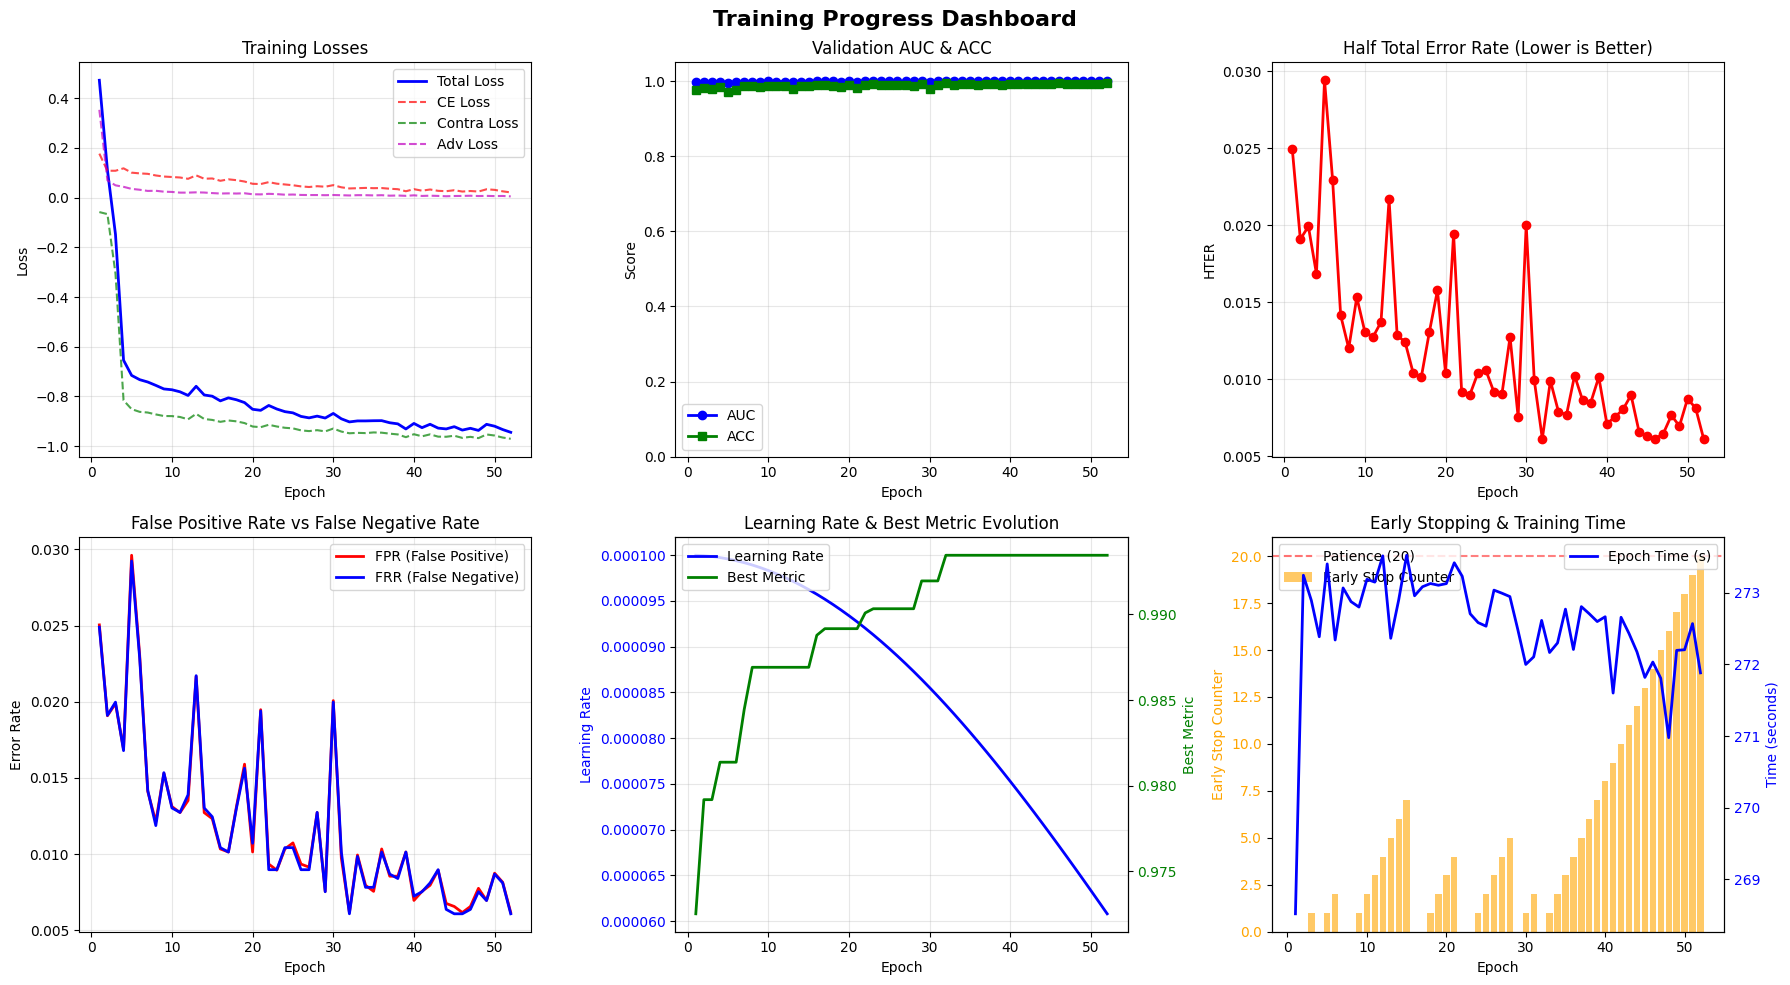


📊 THỐNG KÊ TRAINING:
✓ Best AUC: 0.9996 (epoch 49)
✓ Best ACC: 0.9940 (epoch 32)
✓ Best HTER: 0.0061 (epoch 32)
✓ Lowest Loss: -0.9447 (epoch 52)
✓ Avg epoch time: 272.55s
✓ Total training time: 3.94 hours


In [4]:
# ===== VẼ BIỂU ĐỒ TỪ TRAINING LOG CSV =====
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_log(csv_path="results/ssan_custom/log/training_log.csv"):
    """
    Vẽ biểu đồ từ training_log.csv
    Hỗ trợ cả trường hợp resume (đọc toàn bộ log từ đầu đến giờ)
    """
    if not os.path.exists(csv_path):
        print(f"❌ Không tìm thấy log file: {csv_path}")
        return
    
    # Đọc CSV
    df = pd.read_csv(csv_path)
    
    print(f"📊 Tổng số epochs đã train: {len(df)}")
    print(f"📈 Epoch range: {df['epoch'].min()} → {df['epoch'].max()}")
    
    # Tạo figure với nhiều subplot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training Progress Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Loss curves
    ax = axes[0, 0]
    ax.plot(df['epoch'], df['train_total'], 'b-', label='Total Loss', linewidth=2)
    ax.plot(df['epoch'], df['train_ce'], 'r--', label='CE Loss', alpha=0.7)
    ax.plot(df['epoch'], df['train_contra'], 'g--', label='Contra Loss', alpha=0.7)
    ax.plot(df['epoch'], df['train_adv'], 'm--', label='Adv Loss', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Losses')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Validation metrics (AUC, ACC)
    ax = axes[0, 1]
    ax.plot(df['epoch'], df['val_auc'], 'b-o', label='AUC', linewidth=2)
    ax.plot(df['epoch'], df['val_acc'], 'g-s', label='ACC', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.set_title('Validation AUC & ACC')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])
    
    # 3. HTER (càng thấp càng tốt)
    ax = axes[0, 2]
    ax.plot(df['epoch'], df['val_hter'], 'r-o', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('HTER')
    ax.set_title('Half Total Error Rate (Lower is Better)')
    ax.grid(True, alpha=0.3)
    
    # 4. FPR & FRR
    ax = axes[1, 0]
    ax.plot(df['epoch'], df['val_fpr'], 'r-', label='FPR (False Positive)', linewidth=2)
    ax.plot(df['epoch'], df['val_frr'], 'b-', label='FRR (False Negative)', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error Rate')
    ax.set_title('False Positive Rate vs False Negative Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. Learning rate & Best metric
    ax = axes[1, 1]
    ax2 = ax.twinx()
    line1 = ax.plot(df['epoch'], df['learning_rate'], 'b-', label='Learning Rate', linewidth=2)
    line2 = ax2.plot(df['epoch'], df['best_metric'], 'g-', label='Best Metric', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate', color='b')
    ax2.set_ylabel('Best Metric', color='g')
    ax.set_title('Learning Rate & Best Metric Evolution')
    ax.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='g')
    ax.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')
    
    # 6. Early stopping counter & Epoch time
    ax = axes[1, 2]
    ax2 = ax.twinx()
    line1 = ax.bar(df['epoch'], df['early_stop_counter'], alpha=0.6, label='Early Stop Counter', color='orange')
    line2 = ax2.plot(df['epoch'], df['epoch_time'], 'b-', label='Epoch Time (s)', linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Early Stop Counter', color='orange')
    ax2.set_ylabel('Time (seconds)', color='b')
    ax.set_title('Early Stopping & Training Time')
    ax.tick_params(axis='y', labelcolor='orange')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Add horizontal line for patience
    ax.axhline(y=cfg.early_stop_patience, color='r', linestyle='--', 
               alpha=0.5, label=f'Patience ({cfg.early_stop_patience})')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # In thống kê
    print("\n" + "="*60)
    print("📊 THỐNG KÊ TRAINING:")
    print("="*60)
    print(f"✓ Best AUC: {df['val_auc'].max():.4f} (epoch {df.loc[df['val_auc'].idxmax(), 'epoch']:.0f})")
    print(f"✓ Best ACC: {df['val_acc'].max():.4f} (epoch {df.loc[df['val_acc'].idxmax(), 'epoch']:.0f})")
    print(f"✓ Best HTER: {df['val_hter'].min():.4f} (epoch {df.loc[df['val_hter'].idxmin(), 'epoch']:.0f})")
    print(f"✓ Lowest Loss: {df['train_total'].min():.4f} (epoch {df.loc[df['train_total'].idxmin(), 'epoch']:.0f})")
    print(f"✓ Avg epoch time: {df['epoch_time'].mean():.2f}s")
    print(f"✓ Total training time: {df['epoch_time'].sum()/3600:.2f} hours")
    
    # Kiểm tra xem có resume không
    if len(df) > 0 and df['epoch'].min() > 1:
        print(f"\n⚠️ Log này đã được resume từ epoch {df['epoch'].min()}")

# Vẽ biểu đồ
plot_training_log()

In [9]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# ===== LOAD MODEL SSAN_R =====
def load_ssan_r_model(checkpoint_path, max_iter=10000):
    model = SSAN_R(max_iter=max_iter, num_domains=cfg.num_domains).to(device)
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Trường hợp checkpoint lưu dạng dict
    if "state_dict" in state_dict:
        state_dict = state_dict["state_dict"]
    
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

checkpoint_path = "results/ssan_custom/model/best_model.pth"
model = load_ssan_r_model(checkpoint_path)
print("Model loaded.")

# ===== INFERENCE TRANSFORM =====
test_transform = transformer_test_image()

d:\CODE\face-anti-spoofing-2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CODE\face-anti-spoofing-2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded.


C:\Users\Admin\AppData\Local\Temp\ipykernel_17104\1788754506.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device

----------------------------------------
Prediction: SPOOF
Live probability: 0.0028
----------------------------------------


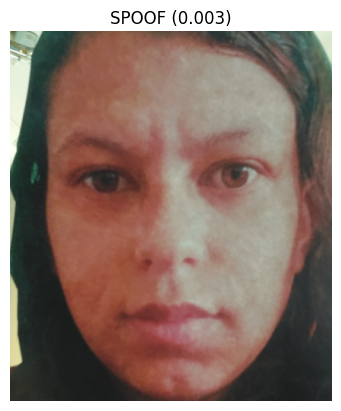

(0.0028316653333604336, 'SPOOF')

In [17]:
# ===== INFERENCE HÀM CHÍNH =====
def infer_image(model, image_path, img_size=256):
    # Load ảnh BGR (giống training)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Không load được ảnh: " + image_path)

    # Resize ảnh BGR (KHÔNG convert sang RGB - để ToTensor() tự convert)
    img_resized = cv2.resize(img, (img_size, img_size))

    # Tạo sample giống dataset train/test
    sample = {
        "image_x": img_resized,  # BGR format (giống training dataset)
        "map_x": np.zeros((cfg.map_size, cfg.map_size), dtype=np.float32),
        "label": 0,
        "UUID": 0
    }

    # Apply transform (ToTensor sẽ convert BGR→RGB tự động)
    sample = test_transform(sample)

    # Convert to batch
    image_tensor = sample["image_x"].unsqueeze(0).to(device)

    # Forward qua model (self-assembly)
    with torch.no_grad():
        logits, _, _, _ = model(image_tensor, image_tensor)
        prob = torch.softmax(logits, dim=1)[0, 1].item()  # xác suất live

    pred = "LIVE" if prob >= 0.5 else "SPOOF"

    print("----------------------------------------")
    print(f"Prediction: {pred}")
    print(f"Live probability: {prob:.4f}")
    print("----------------------------------------")

    # Show ảnh (convert sang RGB để hiển thị đúng màu)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"{pred} ({prob:.3f})")
    plt.axis("off")
    plt.show()

    return prob, pred

# ===== TEST =====
# Thay bằng ảnh của bạn
infer_image(model, "test_img/Screenshot-2025-12-18 094736.png")


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import torch

mp_face = mp.solutions.face_detection
mp_draw = mp.solutions.drawing_utils

# ==== Hàm preprocess frame để tương thích SSAN_R ====
def preprocess_face(face_img):
    """
    Preprocess face image giống hệt test_transform:
    1. Resize về img_size x img_size
    2. BGR → RGB
    3. HWC → CHW
    4. Normalize: (x - 127.5) / 128 (QUAN TRỌNG!)
    """
    # Resize về đúng input model
    face_resized = cv2.resize(face_img, (cfg.img_size, cfg.img_size))

    # BGR → RGB (OpenCV đọc BGR, model train với RGB)
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)
    
    # HWC → CHW
    face_chw = face_rgb.transpose((2, 0, 1))
    
    # Normalize giống training: (x - 127.5) / 128
    face_normalized = (face_chw - 127.5) / 128.0
    
    # Convert to tensor
    face_tensor = torch.from_numpy(face_normalized.astype(np.float32)).to(device)
    
    # Thêm batch dimension
    face_tensor = face_tensor.unsqueeze(0)

    return face_tensor


# ==== WEBCAM ANTI-SPOOFING (IMPROVED) ====
def infer_webcam_multiface(model, camera_id=0, score_thres=0.5, skip=2):
    """
    Real-time face anti-spoofing trên webcam với multi-face support
    
    Args:
        model: SSAN_R model đã load
        camera_id: ID của webcam (0 = webcam mặc định)
        score_thres: Ngưỡng xác suất (>= 0.5 → LIVE)
        skip: Infer mỗi N frames (skip=2 → infer 1/2 frames, mượt hơn)
    
    Controls:
        'q' - Thoát
        's' - Screenshot
    """
    device = next(model.parameters()).device
    model.eval()

    cap = cv2.VideoCapture(camera_id)
    if not cap.isOpened():
        print("❌ Không mở được webcam!")
        return

    # Set resolution cao hơn cho chất lượng tốt hơn
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    print("=" * 60)
    print("🎥 WEBCAM ANTI-SPOOFING STARTED")
    print("=" * 60)
    print("📹 Controls:")
    print("   • Press 'q' to quit")
    print("   • Press 's' to save screenshot")
    print("=" * 60)

    frame_count = 0
    fps_start_time = time.time()
    fps = 0
    
    # Cache cho scores (giữ score của frame trước nếu skip)
    face_scores = {}

    with mp_face.FaceDetection(model_selection=0, min_detection_confidence=0.7) as face_detector:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("⚠️ Không đọc được frame từ webcam")
                break

            h, w, _ = frame.shape
            frame_count += 1
            do_infer = (frame_count % skip == 0)

            # Tính FPS
            if frame_count % 30 == 0:
                fps = 30 / (time.time() - fps_start_time)
                fps_start_time = time.time()

            # -----------------------------
            # 1) FACE DETECTION (downscale để nhanh hơn)
            # -----------------------------
            small_frame = cv2.resize(frame, (640, 360))
            results = face_detector.process(cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB))

            # Scale factors
            h_scale = h / 360
            w_scale = w / 640

            # -----------------------------
            # 2) XỬ LÝ MỖI KHUÔN MẶT
            # -----------------------------
            current_faces = {}
            
            if results.detections:
                for face_id, det in enumerate(results.detections):
                    bbox = det.location_data.relative_bounding_box
                    
                    # Tính bounding box trên frame gốc
                    x1 = int(bbox.xmin * 640 * w_scale)
                    y1 = int(bbox.ymin * 360 * h_scale)
                    x2 = int((bbox.xmin + bbox.width) * 640 * w_scale)
                    y2 = int((bbox.ymin + bbox.height) * 360 * h_scale)

                    # Clipping
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)

                    # Bỏ qua khuôn mặt quá nhỏ
                    if x2 - x1 < 40 or y2 - y1 < 40:
                        continue

                    face_img = frame[y1:y2, x1:x2]

                    # -----------------------------
                    # 3) INFERENCE (chỉ khi do_infer=True)
                    # -----------------------------
                    if do_infer:
                        try:
                            inp = preprocess_face(face_img)

                            with torch.no_grad():
                                logits, _, _, _ = model(inp, inp)
                                prob_live = torch.softmax(logits, dim=1)[0, 1].item()
                            
                            # Cache score
                            current_faces[face_id] = prob_live
                        except Exception as e:
                            print(f"⚠️ Lỗi inference: {e}")
                            current_faces[face_id] = 0.0
                    else:
                        # Dùng score cached từ frame trước
                        current_faces[face_id] = face_scores.get(face_id, 0.0)

                    # -----------------------------
                    # 4) VẼ BOX + TEXT
                    # -----------------------------
                    prob = current_faces[face_id]
                    label = "[LIVE]" if prob >= score_thres else "[SPOOF]"
                    color = (0, 255, 0) if prob >= score_thres else (0, 0, 255)

                    # Vẽ bounding box dày hơn
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 3)
                    
                    # Vẽ background cho text (dễ đọc hơn)
                    text = f"{label} ({prob:.2f})"
                    (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                    cv2.rectangle(frame, (x1, y1 - text_h - 10), (x1 + text_w + 10, y1), color, -1)
                    
                    # Vẽ text
                    cv2.putText(
                        frame, text,
                        (x1 + 5, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, (255, 255, 255), 2
                    )

            # Update cache
            if do_infer:
                face_scores = current_faces

            # -----------------------------
            # 5) HIỂN THỊ FPS & INFO
            # -----------------------------
            info_text = f"FPS: {fps:.1f} | Faces: {len(current_faces)} | Skip: 1/{skip}"
            cv2.putText(frame, info_text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            cv2.imshow("SSAN-R Anti-Spoofing (Press 'q' to quit)", frame)

            # -----------------------------
            # 6) KEYBOARD CONTROLS
            # -----------------------------
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("\n👋 Đã thoát webcam")
                break
            elif key == ord('s'):
                screenshot_path = f"screenshot_{time.strftime('%Y%m%d_%H%M%S')}.jpg"
                cv2.imwrite(screenshot_path, frame)
                print(f"📸 Đã lưu screenshot: {screenshot_path}")

    cap.release()
    cv2.destroyAllWindows()


# ==== CHẠY WEBCAM ====
infer_webcam_multiface(model)


In [ ]:
import os

# cleanup old results
os.system("rm -rf /kaggle/working/*")